In [1]:
# ---------------- Importing used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as st

In [2]:
# ---------------------- Initial details & save path
save_path = 'C:\\Users\\michael.moore\\OneDrive - RSSB\\Python scripts'
date = datetime.today().strftime('%Y-%m-%d')
name = '2024-DWG-Analysis' + '-' + date

In [3]:
# ----------------- parameters
year = '2024/25'
startperiod = 202201
endperiod = 202412
N = 38
fyearpoints = [6.5, 19.5, 31.5]
bigticks = [-0.5, 12.5, 25.5, N - 0.5]
bigticks2 = [-0.5, 12.5, 25.5, N - 0.5]
xlimitend = N - 0.5
ylimitend = 1

In [4]:
# -------------------------- Load CSV 
csv_path = 'C:\\Users\\Micha\\OneDrive\\Projects\\depot_incident_analysis\\csv\\injury_incidents.csv'

# Read CSV into DataFrame
smis_df1 = pd.read_csv(csv_path)

In [5]:
# ------ Finding out structure of dataframe
smis_df1.info()
smis_df1.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   smis_reference      6040 non-null   object 
 1   event_date          6040 non-null   object 
 2   period              6040 non-null   int64  
 3   place               5998 non-null   object 
 4   report_title        6040 non-null   object 
 5   description         6040 non-null   object 
 6   injury_degree_2013  6040 non-null   object 
 7   fwi_2013            6040 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 377.6+ KB


smis_reference         0
event_date             0
period                 0
place                 42
report_title           0
description            0
injury_degree_2013     0
fwi_2013               0
dtype: int64

In [6]:
# --- Looking at dataset sample

smis_df1.head(5)

,smis_reference,event_date,period,place,report_title,description,injury_degree_2013,fwi_2013
0,SMIS309149,2018-04-02 06:00:00.000,201801,Manchester Longsight MDU,Slip trip or fall,Longsight Depot 34 Road; Report of driver trip...,Non-severe,0.001
1,SMIS238120,2018-04-03 11:00:00.000,201801,Tyne Yard,"Person interacting with animal, object, vehic...",PA-SCO staff jarred right wrist whilst scrapin...,Non-severe,0.001
2,SMIS239138,2018-04-03 22:30:00.000,201801,Singlewell IMD,"Person interacting with animal, object, vehic...",PA DU Singlewell MOS sustained a graze on his ...,Non-severe,0.001
3,SMIS238148,2018-04-04 00:00:00.000,201801,Etches Park LMD (Derby),"Person interacting with animal, object, vehic...",Bombardier staff injured at Etches park,Non-severe,0.001
4,SMIS309200,2018-04-04 14:30:00.000,201801,Carlisle St Nicholas Bridge MDU,Slip trip or fall,PA - Lancs and Cumbria DU: IP slipped on chequ...,Non-severe,0.001


In [7]:
# ------------ Identifying unique entries for mapping
print(smis_df1['injury_degree_2013'].unique())

['Non-severe' 'Severe 7' 'Specified' 'Shock/Trauma' 'Shock/Trauma 7'
 'Fatal']


In [8]:
# Define the mapping for injury degree values
injury_map = {
    'Fatal': 'Fatal',
    'Non-severe': 'Non-severe',
    'Severe 7': 'Severe',
    'Severe H': 'Severe',
    'Shock/Trauma': 'Shock/Trauma',
    'Shock/Trauma 7': 'Shock/Trauma',
    'Specified': 'Specified'
}


# Apply the mapping to the 'injury_degree_2013' column and create a new column 'injuries simplified'
smis_df1['injuries simplified'] = smis_df1['injury_degree_2013'].map(injury_map)

In [9]:
# -------------------------------- Grouping data for counts

# Count total events by period
smis_counts1 = smis_df1.groupby(['period'])['injuries simplified'].count().fillna(0)

# sum events by period and category
smis_counts2 = smis_df1.groupby(['period', 'injuries simplified'])['fwi_2013'].sum().unstack('injuries simplified').fillna(0)

# Add a column for total injury incidents
smis_counts2['TotalInjuryIncidents'] = smis_counts2.sum(axis=1)

In [10]:
#make dataframe for results (plus one year before cut off to allow AMTs)
#range of fiscal years in graph
Nyears = 3 #number of years in graph ------ CHANGED FOR ISLG
ymax = int(year[:4])
ymin = int(ymax)-Nyears+1
for i in range(Nyears+1):       
    p1 = np.arange(1,14)
    y1 = int(ymax)-Nyears+i
    y2 = y1+1
    data = pd.DataFrame({'Periods':p1.astype(str)})
    data['Index'] = str(y1)+data['Periods'].str.zfill(2)
    data['Index'] = data['Index'].astype(int)
    data['Periods'] = 'P'+data['Periods']
    data['Fiscal year'] = str(y1)+'/'+str(y2)
    if i==0:
        data1 = data
    else:
        data1 = pd.concat([data1, data],sort=True)

#make smis and sidb dataframes
data1 = data1.set_index('Index')

smis_data2 = data1.join(smis_counts2)
smis_data2 = smis_data2.fillna(0)

In [11]:
# ------------ Calculating annual moving average
smis_data2['Injury Events AMA'] = smis_data2['TotalInjuryIncidents'].rolling(window=13).mean()

In [12]:
# ----------------------------- Setting data cut
smis_data2 = smis_data2[smis_data2.index>=startperiod] #only want periods after this

smis_data2 = smis_data2[smis_data2.index<=endperiod] #only want periods before this


In [13]:
 # ----------------------------- upper and lower bounds
conf_intervals_cut = smis_counts2[smis_counts2.index>=202101]  #cut the data that we will be calculating the upper and lower bounds on
conf_intervals_cut = conf_intervals_cut[conf_intervals_cut.index<=202213]  #cut the data that we will be calculating the upper and lower bounds on

conf_intervals_mean = np.mean(conf_intervals_cut['TotalInjuryIncidents']) #calculate the mean of the cut of data

bounds = st.norm.interval(confidence=0.95, loc=conf_intervals_mean, scale=st.sem(conf_intervals_cut['TotalInjuryIncidents']))       #I think it is correct to use the standard error of the mean as we are looking at the whole population

lowerbound = bounds[0]
upperbound = bounds[1]


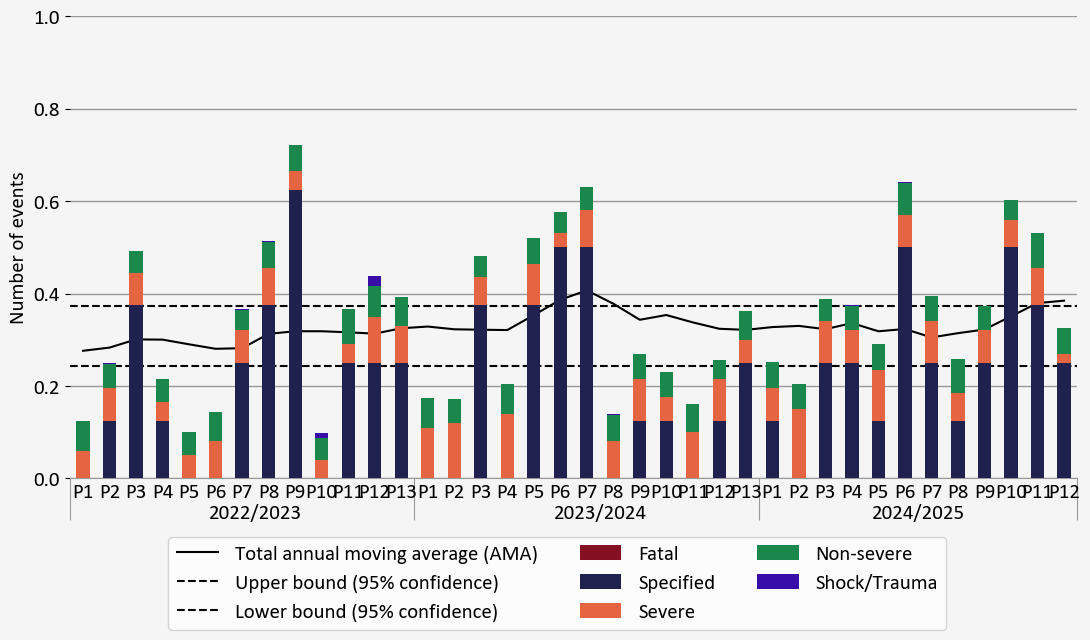

In [14]:
# ----------------- Drawing chart
#set font parameters
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.size'] = 15.0

#parameters for graphs
fig = plt.figure(figsize=(13, 6))
width = 0.5
ind = np.arange(0,N,1)
bordercolour = '0.6'
#graphtitle = 'Trend in Contact with object events' #graph title

fatalbar = np.array(smis_data2['Fatal'])
severebar = np.array(smis_data2['Severe'])
shocktraumabar = np.array(smis_data2['Shock/Trauma'])
specifiedbar = np.array(smis_data2['Specified'])
nonseverebar = np.array(smis_data2['Non-severe'])

#x tick mark locations for all graphs
ticks1 = np.arange(0,N,1) #set tick intervals
ticklabels1 = smis_data2['Periods'].iloc[ticks1] #get labels at correct intervals
ticklabels1 = ticklabels1.tolist()
fyears = '\n' + smis_data2['Fiscal year'].dropna().unique() #fiscal years (\n makes it go one line below)
ticklabels1 = ticklabels1 + fyears.tolist()
ticks1 = ticks1.tolist() + fyearpoints

ax1 = fig.add_subplot(1,1,1)
#set labels
ax1.set(ylabel='Number of events')
#set xticks
ax1.set_xlim(-0.5,xlimitend)
ax1.set_ylim(0,ylimitend)
ax1.set_xticks(ticks1, minor=True)
ax1.set_xticklabels(ticklabels1, minor=True)
ax1.set_xticks(bigticks)
ax1.set_xticklabels([])
ax1.tick_params(axis='x',which='minor',length=0)
ax1.tick_params(axis='x',which='major',length=30,color=bordercolour)


#gridlines
ax1.yaxis.grid(which="major", color=bordercolour, linestyle='-', linewidth=1, zorder=0) #add gridlines
#plot bar graph

ax1.bar(ind, fatalbar, width, color=(133/255, 16/255, 36/255), zorder=3, label='Fatal')
ax1.bar(ind, specifiedbar, width, color=(33/255, 33/255, 79/255), zorder=3, 
        bottom=fatalbar, label='Specified')
ax1.bar(ind, severebar, width, color=(229/255, 101/255, 66/255), zorder=3, 
        bottom=fatalbar + specifiedbar, label='Severe')
ax1.bar(ind, nonseverebar, width, color=(27/255, 135/255, 76/255), zorder=3, 
        bottom=fatalbar + specifiedbar + severebar, label='Non-severe')
ax1.bar(ind, shocktraumabar, width, color=(57/255, 13/255, 168/255), zorder=3, 
        bottom=fatalbar + specifiedbar + severebar + nonseverebar, label='Shock/Trauma')



ax1.plot(ind, smis_data2['Injury Events AMA'], color='black',label='Total annual moving average (AMA)')

############
# Confidence intervals - NOT USING AT THE MOMENT
ax1.plot([-0.5,xlimitend],[upperbound,upperbound], ls='--', color='black', label='Upper bound (95% confidence)')      
ax1.plot([-0.5,xlimitend],[lowerbound,lowerbound], ls='--', color='black', label='Lower bound (95% confidence)')
###########

# Numbers on the top of each bar
#for i in ind:
    #ax1.text(x=ind[i], y=height[i], s=np.round(height[i], 1), ha='center', va='bottom')
#remove borders and change colours
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_color(bordercolour)
ax1.set_facecolor('whitesmoke')

# Move legend to bottom of plot
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=3) 


fig.patch.set_facecolor('whitesmoke')
plt.show()
